In [1]:
%matplotlib inline

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog
import time

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

# Import everything needed to edit/save/watch video clips
#import imageio
#imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

/root/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
data_dir = './data'

In [3]:
import utils

In [4]:
# Common params

use_hog = True
use_hist = True
use_spatial = True
colorspace = 'YCrCb'
hog_channel = 0
cells_per_step=2
orient = 9
window=64
color_feature_size=(64, 64)
pix_per_cell=8
cell_per_block = 4
ystart = 400
ystop = 656
scale = 1.5
spatial_size = (32, 32)
hist_bins = 32
hist_range = (0, 255)
sample_size = None

In [5]:

# Divide up into cars and notcars
cars = glob.glob(data_dir+'/vehicles/*/*.png')
notcars = glob.glob(data_dir+'/non-vehicles/*/*.png')

print(len(cars))
print(len(notcars))

print("Training SVM..")

# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
if sample_size:
    print("Subsampling the first {} samples for training..".format(sample_size))
    cars = cars[0:sample_size]
    notcars = notcars[0:sample_size]

t=time.time()
car_features = utils.extract_features(cars, colorspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_size=spatial_size,
                        hist_bins=hist_bins, debug=False)
notcar_features = utils.extract_features(notcars, colorspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_size=spatial_size,
                        hist_bins=hist_bins)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

8792
8968
Training SVM..
30.84 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 4 cells per block
Feature vector length: 6768
12.75 Seconds to train SVC...
Test Accuracy of SVC =  0.9837
My SVC predicts:  [ 0.  1.  0.  1.  0.  0.  0.  1.  0.  1.]
For these 10 labels:  [ 0.  1.  0.  1.  0.  0.  0.  1.  0.  1.]
0.00158 Seconds to predict 10 labels with SVC


In [6]:
def find_cars(img, debug=False):
    if debug:
        draw_img = np.copy(img)
    
    img = utils.normalize_image(img, factor=(1 / 255.), colorspace=colorspace)

    img = utils.get_subimg(img, ystart, ystop, scale)

    if use_hog:
        hog_features_full = utils.get_hog_features(img, orient, pix_per_cell, cell_per_block, hog_channel=hog_channel, feature_vec=False)

    nblocks_per_window, nxsteps, nysteps = utils.get_search_plan(img, pix_per_cell, cell_per_block, window=window, cells_per_step=cells_per_step)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            subimg_features = []
            
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step

            if use_hog:
                # Extract HOG for this patch
                if hog_channel == 'ALL':
                    hog_feat1 = hog_features_full[0][ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                    hog_feat2 = hog_features_full[1][ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                    hog_feat3 = hog_features_full[2][ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                    hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                else:
                    hog_features = hog_features_full[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                subimg_features.append(hog_features)
                if debug:
                    print('hog_features_shape', hog_features.shape)

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            # Get color features
            if use_hog or use_hist:
                # Extract the image patch to prepare feature extraction.
                subimg = cv2.resize(img[ytop:ytop + window, xleft:xleft + window], color_feature_size)

                if use_spatial:
                    spatial_features = utils.bin_spatial(subimg, size=spatial_size)
                    subimg_features.append(spatial_features)
                    if debug:
                        print('spatial_features shape', spatial_features.shape)
                if use_hist:
                    hist_features = utils.color_hist(subimg, nbins=hist_bins)
                    subimg_features.append(hist_features)
                    if debug:
                        print('hist_features_shape', hist_features.shape)
            subimg_features = np.concatenate(subimg_features)
            if debug:
                print("subimg_features shape", subimg_features.shape)
            
            #test_features = X_scaler.transform(all_features).reshape(1, -1)
            test_features = subimg_features.reshape(1, -1) 
            
            if debug:
                print("test_features shape", test_features.shape)
            
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
    
    return draw_img
    

hog_features_shape (3600,)
spatial_features shape (3072,)
hist_features_shape (96,)
subimg_features shape (6768,)
test_features shape (1, 6768)
hog_features_shape (3600,)
spatial_features shape (3072,)
hist_features_shape (96,)
subimg_features shape (6768,)
test_features shape (1, 6768)
hog_features_shape (3600,)
spatial_features shape (3072,)
hist_features_shape (96,)
subimg_features shape (6768,)
test_features shape (1, 6768)
hog_features_shape (3600,)
spatial_features shape (3072,)
hist_features_shape (96,)
subimg_features shape (6768,)
test_features shape (1, 6768)
hog_features_shape (3600,)
spatial_features shape (3072,)
hist_features_shape (96,)
subimg_features shape (6768,)
test_features shape (1, 6768)
hog_features_shape (3600,)
spatial_features shape (3072,)
hist_features_shape (96,)
subimg_features shape (6768,)
test_features shape (1, 6768)
hog_features_shape (3600,)
spatial_features shape (3072,)
hist_features_shape (96,)
subimg_features shape (6768,)
test_features shape (1

hist_features_shape (96,)
subimg_features shape (6768,)
test_features shape (1, 6768)
hog_features_shape (3600,)
spatial_features shape (3072,)
hist_features_shape (96,)
subimg_features shape (6768,)
test_features shape (1, 6768)
hog_features_shape (3600,)
spatial_features shape (3072,)
hist_features_shape (96,)
subimg_features shape (6768,)
test_features shape (1, 6768)
hog_features_shape (3600,)
spatial_features shape (3072,)
hist_features_shape (96,)
subimg_features shape (6768,)
test_features shape (1, 6768)
hog_features_shape (3600,)
spatial_features shape (3072,)
hist_features_shape (96,)
subimg_features shape (6768,)
test_features shape (1, 6768)
hog_features_shape (3600,)
spatial_features shape (3072,)
hist_features_shape (96,)
subimg_features shape (6768,)
test_features shape (1, 6768)
hog_features_shape (3600,)
spatial_features shape (3072,)
hist_features_shape (96,)
subimg_features shape (6768,)
test_features shape (1, 6768)
hog_features_shape (3600,)
spatial_features shape 

test_features shape (1, 6768)
hog_features_shape (3600,)
spatial_features shape (3072,)
hist_features_shape (96,)
subimg_features shape (6768,)
test_features shape (1, 6768)
hog_features_shape (3600,)
spatial_features shape (3072,)
hist_features_shape (96,)
subimg_features shape (6768,)
test_features shape (1, 6768)
hog_features_shape (3600,)
spatial_features shape (3072,)
hist_features_shape (96,)
subimg_features shape (6768,)
test_features shape (1, 6768)
hog_features_shape (3600,)
spatial_features shape (3072,)
hist_features_shape (96,)
subimg_features shape (6768,)
test_features shape (1, 6768)
hog_features_shape (3600,)
spatial_features shape (3072,)
hist_features_shape (96,)
subimg_features shape (6768,)
test_features shape (1, 6768)
hog_features_shape (3600,)
spatial_features shape (3072,)
hist_features_shape (96,)
subimg_features shape (6768,)
test_features shape (1, 6768)
hog_features_shape (3600,)
spatial_features shape (3072,)
hist_features_shape (96,)
subimg_features shape 

hist_features_shape (96,)
subimg_features shape (6768,)
test_features shape (1, 6768)
hog_features_shape (3600,)
spatial_features shape (3072,)
hist_features_shape (96,)
subimg_features shape (6768,)
test_features shape (1, 6768)
hog_features_shape (3600,)
spatial_features shape (3072,)
hist_features_shape (96,)
subimg_features shape (6768,)
test_features shape (1, 6768)
hog_features_shape (3600,)
spatial_features shape (3072,)
hist_features_shape (96,)
subimg_features shape (6768,)
test_features shape (1, 6768)
hog_features_shape (3600,)
spatial_features shape (3072,)
hist_features_shape (96,)
subimg_features shape (6768,)
test_features shape (1, 6768)
hog_features_shape (3600,)
spatial_features shape (3072,)
hist_features_shape (96,)
subimg_features shape (6768,)
test_features shape (1, 6768)
hog_features_shape (3600,)
spatial_features shape (3072,)
hist_features_shape (96,)
subimg_features shape (6768,)
test_features shape (1, 6768)
hog_features_shape (3600,)
spatial_features shape 

hist_features_shape (96,)
subimg_features shape (6768,)
test_features shape (1, 6768)
hog_features_shape (3600,)
spatial_features shape (3072,)
hist_features_shape (96,)
subimg_features shape (6768,)
test_features shape (1, 6768)
hog_features_shape (3600,)
spatial_features shape (3072,)
hist_features_shape (96,)
subimg_features shape (6768,)
test_features shape (1, 6768)
hog_features_shape (3600,)
spatial_features shape (3072,)
hist_features_shape (96,)
subimg_features shape (6768,)
test_features shape (1, 6768)
hog_features_shape (3600,)
spatial_features shape (3072,)
hist_features_shape (96,)
subimg_features shape (6768,)
test_features shape (1, 6768)
hog_features_shape (3600,)
spatial_features shape (3072,)
hist_features_shape (96,)
subimg_features shape (6768,)
test_features shape (1, 6768)
hog_features_shape (3600,)
spatial_features shape (3072,)
hist_features_shape (96,)
subimg_features shape (6768,)
test_features shape (1, 6768)
hog_features_shape (3600,)
spatial_features shape 

hist_features_shape (96,)
subimg_features shape (6768,)
test_features shape (1, 6768)
hog_features_shape (3600,)
spatial_features shape (3072,)
hist_features_shape (96,)
subimg_features shape (6768,)
test_features shape (1, 6768)
hog_features_shape (3600,)
spatial_features shape (3072,)
hist_features_shape (96,)
subimg_features shape (6768,)
test_features shape (1, 6768)
hog_features_shape (3600,)
spatial_features shape (3072,)
hist_features_shape (96,)
subimg_features shape (6768,)
test_features shape (1, 6768)
hog_features_shape (3600,)
spatial_features shape (3072,)
hist_features_shape (96,)
subimg_features shape (6768,)
test_features shape (1, 6768)
hog_features_shape (3600,)
spatial_features shape (3072,)
hist_features_shape (96,)
subimg_features shape (6768,)
test_features shape (1, 6768)
hog_features_shape (3600,)
spatial_features shape (3072,)
hist_features_shape (96,)
subimg_features shape (6768,)
test_features shape (1, 6768)
hog_features_shape (3600,)
spatial_features shape 

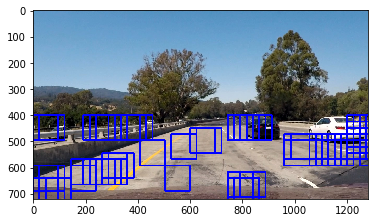

In [7]:
ystart = 400
ystop = 656
scale = 1.5

img = mpimg.imread('test_images/test1.jpg')

    
out_img = find_cars(img, debug=True)



plt.imshow(out_img)

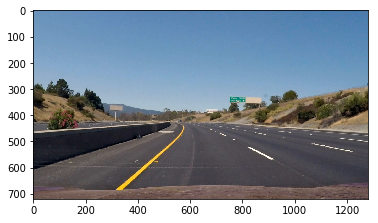

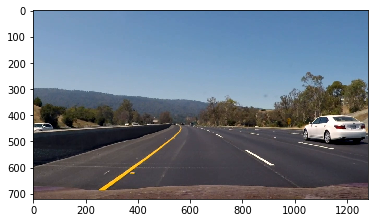

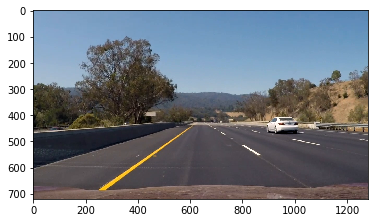

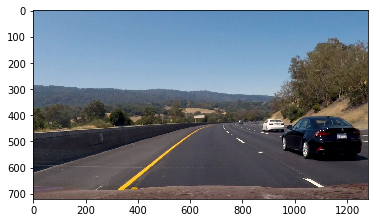

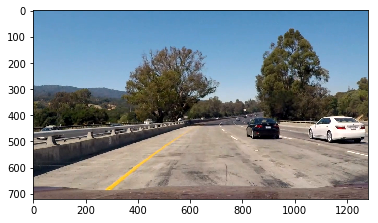

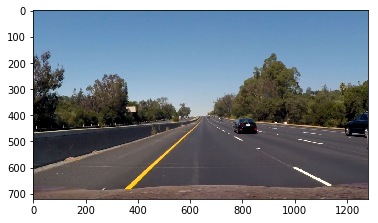

In [8]:
clip = VideoFileClip('project_video.mp4')
for frame in clip.iter_frames(fps=0.1):
    #result = process_frame(frame, debug=False)
    plt.imshow(frame)
    plt.show()